In [18]:
import typing
from simulation_env.environment_basic.environment_basic import CropRotationEnv as CropRotationEnv_Basic
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv as CropRotationEnv_Advanced
from models.basic.DQN_Prioritized import DeepQAgent as DQN_Prioritized
from models.basic.DQN_Prioritized_Symbolic import DeepQAgent as DQN_Prioritized_Symbolic
from models.advanced.SAC import SACAgent
from models.advanced.SAC_Symbolic import SACAgent as SACAgent_Symbolic
from models.advanced.fake_env import FakeEnv
import numpy as np
from utils.experiment_utils import run_experiment, plot_experiment, plot_losses, plot_losses_sac
import torch
from torch import optim
from itertools import count
import collections
from numpy import random
import typing
import pprint
import optuna
from optuna.trial import TrialState
import math
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
from models.advanced.model_utilities import format_samples_for_training, create_full_replay_buffer, plot_mse_and_kl_losses_per_key
seed = 43
random_state1 = np.random.RandomState(seed)
random_state2 = np.random.RandomState(seed+1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CropRotationEnv_Advanced(
    seq_len = 10, 
    random_state = random_state1,
    DryWetInit = None, 
    GroundTypeInit = None, 
    deterministic = False
    )




experience_buffer_size = 50000
experience_replay_buffer = create_full_replay_buffer(length = experience_buffer_size, seq_len=10, random_state = random_state1, batch_size = 128, device = device)

test_set_size = 500
test_replay_buffer = create_full_replay_buffer(length = test_set_size, seq_len=10, random_state = random_state2, batch_size = 128, device = device)
_, test_experiences = test_replay_buffer.uniform_sample(replace = False,batch_size=test_set_size)
states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*test_experiences))
test_inputs, test_outputs = format_samples_for_training(
    states=states, 
    actions = actions, 
    rewards = rewards, 
    next_states = next_states,
    device = device,
    num_actions = env.num_crops,
    )

KeyboardInterrupt: 

# Train all models

Model-Utilities: Custom model setting dict loaded
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Epi

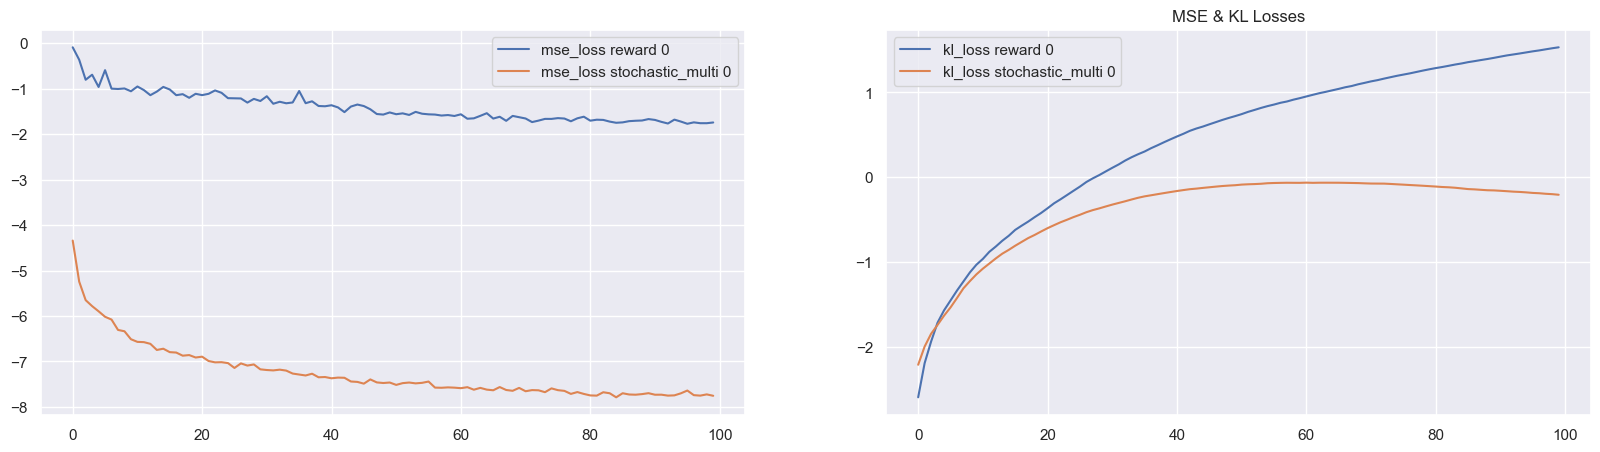

- MSE : 0.176272, KL : 4.676017


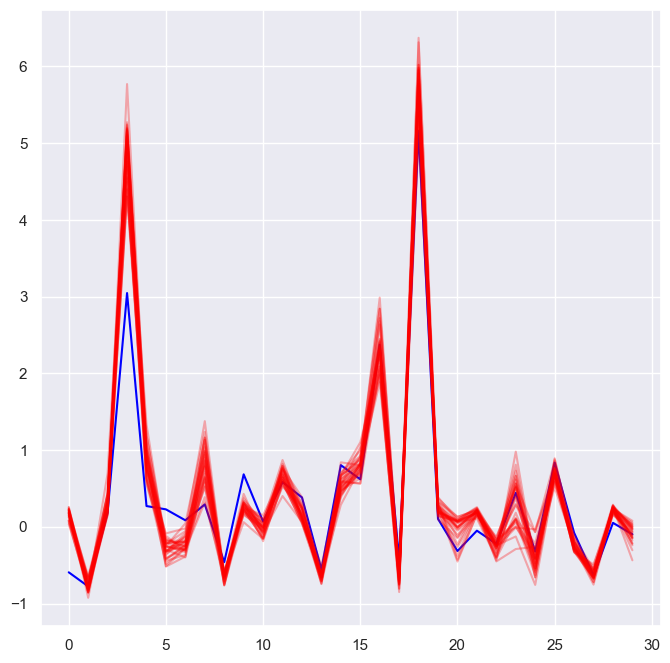

- MSE : 0.000457, KL : 0.810826


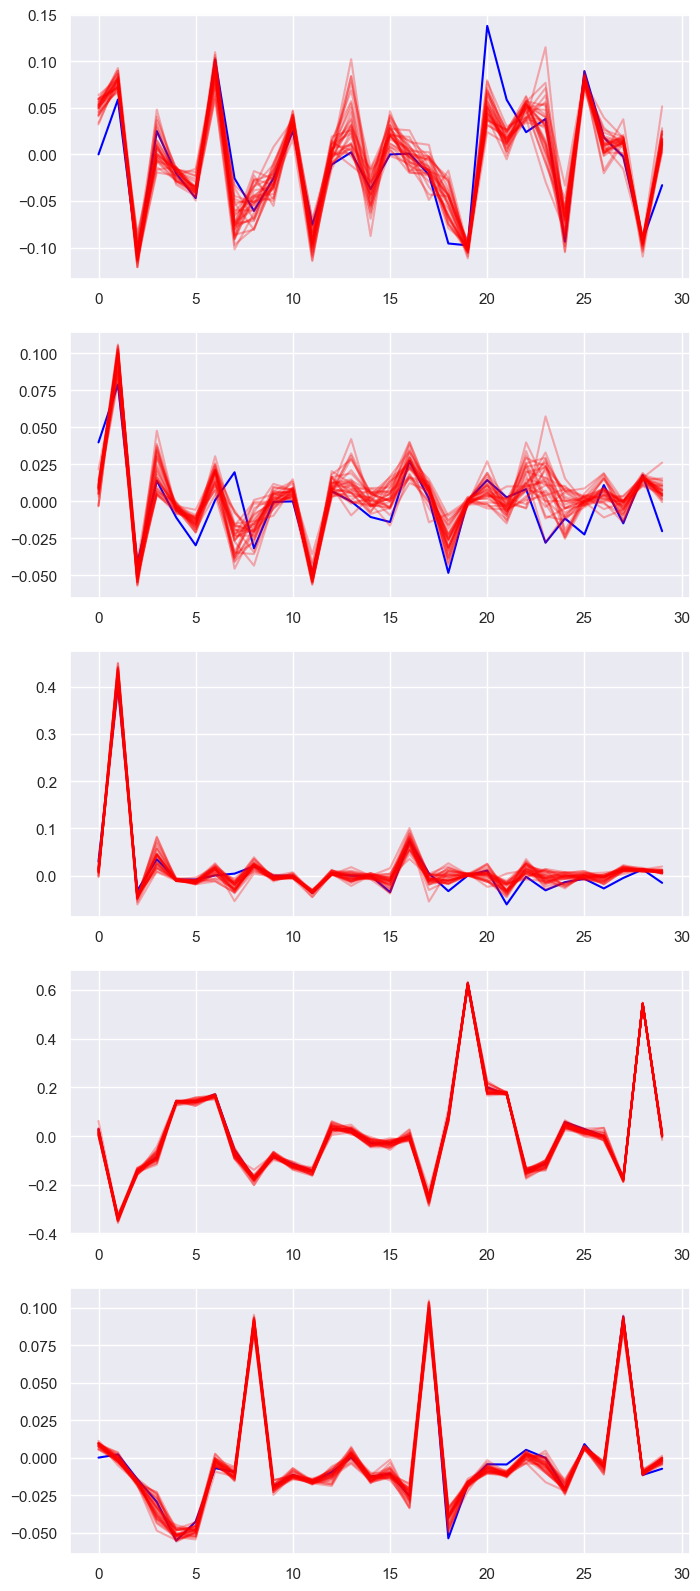

In [ ]:
from models.advanced.model_utilities import plot_validation_fit
import torch.nn as nn
dynamics_model_batch_size = 256
num_dynamics_model_training_steps = 10

batch_size = 128
buffer_size = 50000
num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))


# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_prices_and_costs_idxs = [8,9,10] + list(range(11,11+3*num_crops))

custom_model_setting_dict = {    
    "stochastic_multi": {
        "type": "stochastic",
        "input_size": len(input_action_idxs + input_condition_idxs),
        "output_size": len(target_stochastic_multi_idxs),
        "num_hidden_units": 128,
        "num_hidden_layers": 5,
        "activation": nn.ReLU(),
        "input_idxs": input_action_idxs + input_condition_idxs,
        "target_idxs": target_stochastic_multi_idxs,
        "lr": 0.00089,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000135,
        "num_models": 1,
        "stochastic_layer_type": "stochastic_single"
    },
    "reward": {
        "type": "stochastic",
        "input_size": num_input_dimensions,
        "output_size": 1,
        "num_hidden_units": 128,
        "num_hidden_layers": 5,
        "activation": nn.ReLU(),
        "input_idxs": list(range(num_input_dimensions)),
        "target_idxs": [0],
        "lr": 0.001,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000066,
        "num_models": 1,
        "stochastic_layer_type": "stochastic_single"
    }
}


fake_env = FakeEnv(device = device, random_state = random_state1, custom_model_setting_dict=custom_model_setting_dict)
num_dynamics_models = fake_env.get_num_models()
dynamics_model_keys = fake_env.get_model_keys()
dynamics_all_mean_mse_losses = {}
dynamics_all_mean_kl_losses = {}
for model_key in dynamics_model_keys:
    dynamics_all_mean_mse_losses[model_key] = []
    dynamics_all_mean_kl_losses[model_key] = []

for i in range(500):
    print("Episode",i)
    fake_env.train(
        replay_buffer = experience_replay_buffer, 
        num_steps = num_dynamics_model_training_steps, 
        batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
    )
    if i%10 == 0:
        dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval(test_inputs, test_outputs)
        for model_key in dynamics_model_keys:
            dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
            dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))

plot_mse_and_kl_losses_per_key(dynamics_all_mean_mse_losses, dynamics_all_mean_kl_losses)
plot_validation_fit(fake_env.model_loss_optimizer_pool, test_inputs, test_outputs, plot_range = 30)

# Train Single Model

In [ ]:
from models.advanced.model_utilities import plot_validation_fit_single_model

seed = 43
model_key = "reward"
model_idx = 0
dynamics_model_batch_size = 256
num_dynamics_model_training_steps = 10
random_state1 = np.random.RandomState(seed)

fake_env = FakeEnv(device = device, random_state = random_state1)
dynamics_all_mean_mse_losses = {}
dynamics_all_mean_kl_losses = {}
dynamics_all_mean_mse_losses[model_key] = []
dynamics_all_mean_kl_losses[model_key] = []

for i in range(2000):
    fake_env.train_single(
        model_key = model_key,
        model_idx= model_idx,
        replay_buffer = experience_replay_buffer, 
        num_steps = num_dynamics_model_training_steps, 
        batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
    )
    if i%10 == 0:
        print("Episode",i)
        dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval_single_model(
            model_key = model_key,
            model_idx = model_idx,
            test_inputs = test_inputs, 
            test_outputs = test_outputs,)
        dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
        dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))

plot_mse_and_kl_losses_per_key(dynamics_all_mean_mse_losses, dynamics_all_mean_kl_losses)
plot_validation_fit_single_model(
    fake_env.model_loss_optimizer_pool, 
    test_inputs, 
    test_outputs,
    model_key = model_key,
    model_idx = model_idx, 
    plot_range = 30)

# Train single model iteratively

Model-Utilities: Custom model setting dict loaded
Episode 0
Episode 10
Episode 20
Episode 30
Episode 40
Episode 50
Episode 60
Episode 70
Episode 80
Episode 90


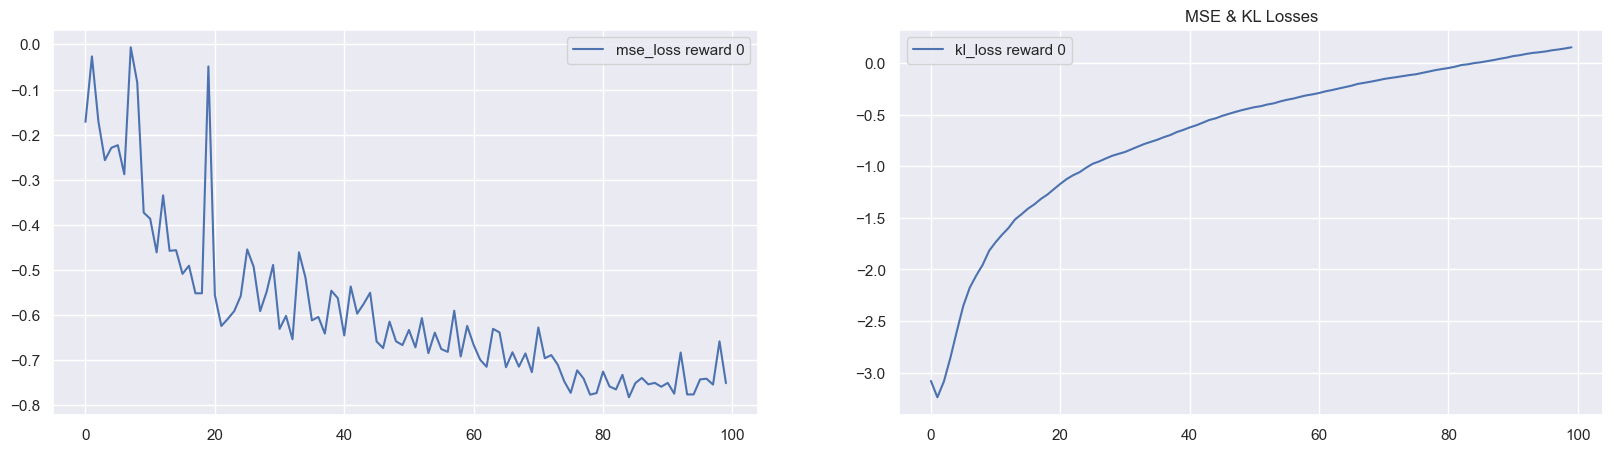

- MSE : 0.464055, KL : 1.166513


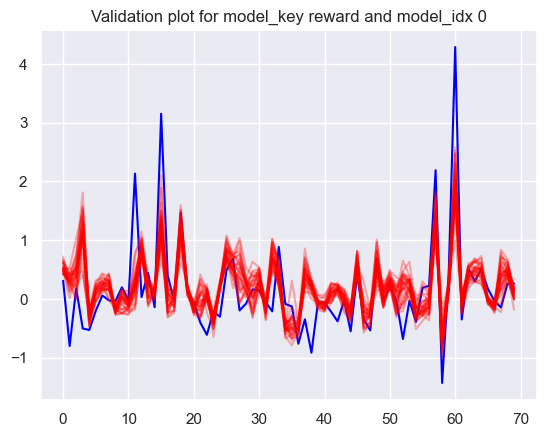

In [41]:
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
import numpy as np
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv as CropRotationEnv_Advanced
from models.advanced.fake_env import FakeEnv
import numpy as np
from utils.experiment_utils import run_experiment, plot_experiment, plot_losses, plot_losses_sac
import torch
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
from models.advanced.model_utilities import plot_mse_and_kl_losses_per_key, plot_validation_fit_single_model
import torch.nn as nn
from numpy import random
batch_size = 128
buffer_size = 50000
num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))


# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_prices_and_costs_idxs = [8,9,10] + list(range(11,11+3*num_crops))

seed = 43
random_state1 = np.random.RandomState(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CropRotationEnv_Advanced(
    seq_len = 10, 
    random_state = random_state1, 
    DryWetInit = None, 
    GroundTypeInit = None, 
    deterministic = False
    )
reward_factor = 5.0/(env.max_reward-env.min_reward)

experience_replay_buffer = UniformReplayBuffer(batch_size = batch_size,
                                    buffer_size = buffer_size,
                                    random_state=random_state1)

model_key = "reward"
model_idx = 0
dynamics_model_batch_size = 32
num_dynamics_model_training_steps = 5

custom_model_setting_dict = {    
    "stochastic_multi": {
        "type": "stochastic",
        "input_size": len(input_action_idxs + input_condition_idxs),
        "output_size": len(target_stochastic_multi_idxs),
        "num_hidden_units": 933,
        "num_hidden_layers": 3,
        "activation": nn.ReLU(),
        "input_idxs": input_action_idxs + input_condition_idxs,
        "target_idxs": target_stochastic_multi_idxs,
        "lr": 0.00089,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000135,
        "num_models": 1,
        "stochastic_layer_type": "stochastic_single"
    },
    "reward": {
        "type": "stochastic",
        "input_size": num_input_dimensions,
        "output_size": 1,
        "num_hidden_units": 128,
        "num_hidden_layers": 5,
        "activation": nn.ReLU(),
        "input_idxs": list(range(num_input_dimensions)),
        "target_idxs": [0],
        "lr": 0.001,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000066,
        "num_models": 1,
        "stochastic_layer_type": "stochastic_single"
    }
}




fake_env = FakeEnv(device = device, random_state = random_state1, custom_model_setting_dict=custom_model_setting_dict)
dynamics_all_mean_mse_losses = {}
dynamics_all_mean_kl_losses = {}
dynamics_all_mean_mse_losses[model_key] = []
dynamics_all_mean_kl_losses[model_key] = []

for i in range(100):
    if i%10 == 0:   
        print("Episode",i)
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, _, reward, done, _ = env.step(action)
        if done:
            break
        if next_state is None:
            print("next_state is None")

        reward_tensor = torch.tensor([reward], device=device)*reward_factor
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        action_tensor = torch.tensor([action]).to(device)
        experience = Experience(state, action_tensor.view(1,1), reward_tensor.view(1,1), next_state_tensor, torch.tensor([done]).view(1,1))
        # print("Stats:", replay_buffer.buffer_size, replay_buffer.batch_size, replay_buffer._buffer_length, replay_buffer._current_idx)
        experience_replay_buffer.add(experience)
        state = next_state_tensor

        fake_env.train_single(
            model_key = model_key,
            model_idx= model_idx,
            replay_buffer = experience_replay_buffer, 
            # num_steps = min(int(experience_replay_buffer.buffer_length/dynamics_model_batch_size)+1, num_dynamics_model_training_steps), 
            num_steps = num_dynamics_model_training_steps, 
            batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
        )

    dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval_single_model(
        model_key = model_key,
        model_idx = model_idx,
        test_inputs = test_inputs, 
        test_outputs = test_outputs,)
    dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
    dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))

plot_mse_and_kl_losses_per_key(dynamics_all_mean_mse_losses, dynamics_all_mean_kl_losses)
plot_validation_fit_single_model(
    fake_env.model_loss_optimizer_pool, 
    test_inputs, 
    test_outputs,
    model_key = model_key,
    model_idx = model_idx, 
    plot_range = 70)

# Optuna study for models

In [15]:
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
import numpy as np
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv as CropRotationEnv_Advanced
from models.advanced.fake_env import FakeEnv
import numpy as np
from utils.experiment_utils import run_experiment, plot_experiment, plot_losses, plot_losses_sac
import torch
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
from models.advanced.model_utilities import plot_mse_and_kl_losses_per_key, plot_validation_fit_single_model
import optuna
import torch.nn as nn

# Create pprinter
pp = pprint.PrettyPrinter(indent=4)

seed = 42
batch_size = 128
buffer_size = 50000
num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))


# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_prices_and_costs_idxs = [8,9,10] + list(range(11,11+3*num_crops))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

reward_factor = 5.0/(env.max_reward-env.min_reward)

def objective(
        trial, 
        model_key,
        num_episodes):
    custom_model_setting_dict = {    
        "stochastic_multi": {
            "type": "stochastic",
            "input_size": len(input_action_idxs + input_condition_idxs),
            "output_size": len(target_stochastic_multi_idxs),
            "num_hidden_units": 933,
            "num_hidden_layers": 3,
            "activation": nn.ReLU(),
            "input_idxs": input_action_idxs + input_condition_idxs,
            "target_idxs": target_stochastic_multi_idxs,
            "lr": 0.00089,
            "weight_decay": 9.18e-08,
            "kl_weight": 0.000135,
            "num_models": 3,
            "stochastic_layer_type": "stochastic_single"
        },
        "reward": {
            "type": "stochastic",
            "input_size": num_input_dimensions,
            "output_size": 1,
            "num_hidden_units": 256,
            "num_hidden_layers": 1,
            "activation": nn.ReLU(),
            "input_idxs": list(range(num_input_dimensions)),
            "target_idxs": [0],
            "lr": 1.53e-02,
            "weight_decay": 2.8e-05,
            "kl_weight": 0.0066,
            "num_models": 3,
            "stochastic_layer_type": "stochastic_single"
        }
    }
    # if model_key == "reward":
    #     custom_model_setting_dict = {
    #         "reward": {
    #             "type": "stochastic",
    #             "input_size": num_input_dimensions,
    #             "output_size": 1,
    #             "num_hidden_units": trial.suggest_int("num_hidden_units", 16, 1024),
    #             "num_hidden_layers": trial.suggest_int("num_hidden_layers", 1, 3),
    #             "activation": nn.ReLU(),
    #             "input_idxs": list(range(num_input_dimensions)),
    #             "target_idxs": [0],
    #             "lr": trial.suggest_float("lr", 1e-7, 1e-1, log=True),
    #             "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True),
    #             "kl_weight": trial.suggest_float("kl_weight", 1e-5, 1e-1, log=True),
    #             "num_models": 1,
    #             "stochastic_layer_type": "stochastic_single"
    #         }}
    # elif model_key == "stochastic_multi":
    #     custom_model_setting_dict = {
    #         "stochastic_multi": {
    #             "type": "stochastic",
    #             "input_size": len(input_action_idxs + input_condition_idxs),
    #             "output_size": len(target_stochastic_multi_idxs),
    #             "num_hidden_units": trial.suggest_int("num_hidden_units", 16, 1024),
    #             "num_hidden_layers": trial.suggest_int("num_hidden_layers", 1, 3),
    #             "activation": nn.ReLU(),
    #             "input_idxs": input_action_idxs + input_condition_idxs,
    #             "target_idxs": target_stochastic_multi_idxs,
    #             "lr": trial.suggest_float("lr", 1e-7, 1e-1, log=True),
    #             "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True),
    #             "kl_weight": trial.suggest_float("kl_weight", 1e-5, 1e-1, log=True),
    #             "num_models": 1,
    #             "stochastic_layer_type": "stochastic_single"
    #         }
    #     }


    random_state1 = np.random.RandomState(seed)
    experience_replay_buffer = UniformReplayBuffer(batch_size = batch_size,
                                        buffer_size = buffer_size,
                                        random_state=random_state1)
    env = CropRotationEnv_Advanced(
        seq_len = 10, 
        random_state = random_state1,
        DryWetInit = None, 
        GroundTypeInit = None, 
        deterministic = False
        )

    model_idx = 0
    dynamics_model_batch_size = trial.suggest_int("batch_size", 32, 512)
    num_dynamics_model_training_steps = trial.suggest_int("num_dynamics_model_training_steps", 1, 3)

    fake_env = FakeEnv(device = device, random_state = random_state1 custom_model_setting_dict=custom_model_setting_dict)
    dynamics_all_mean_mse_losses = {}
    dynamics_all_mean_kl_losses = {}
    dynamics_all_mean_mse_losses[model_key] = []
    dynamics_all_mean_kl_losses[model_key] = []

    for i in range(num_episodes):
        # if i%10 == 0:   
        #     print("Episode",i)
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done = False
        while not done:
            action = env.action_space.sample()
            next_state, _, reward, done, _ = env.step(action)
            if done:
                break
            if next_state is None:
                print("next_state is None")

            reward_tensor = torch.tensor([reward], device=device)*reward_factor
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            action_tensor = torch.tensor([action]).to(device)
            experience = Experience(state, action_tensor.view(1,1), reward_tensor.view(1,1), next_state_tensor, torch.tensor([done]).view(1,1))
            # print("Stats:", replay_buffer.buffer_size, replay_buffer.batch_size, replay_buffer._buffer_length, replay_buffer._current_idx)
            experience_replay_buffer.add(experience)
            state = next_state_tensor
            fake_env.train_single(
                model_key = model_key,
                model_idx= model_idx,
                replay_buffer = experience_replay_buffer, 
                num_steps = num_dynamics_model_training_steps, 
                batch_size = min(experience_replay_buffer.buffer_length, dynamics_model_batch_size)
            )

        dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval_single_model(
            model_key = model_key,
            model_idx = model_idx,
            test_inputs = test_inputs, 
            test_outputs = test_outputs,)
        dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
        dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))
    return np.mean(dynamics_mean_mse_losses[model_key][-20:]), np.mean(dynamics_mean_kl_losses[model_key][-20:])
    

def run_optuna_study(
        model_key,
        num_episodes,
        n_trials=2,
        timeout=600,):
    study = optuna.create_study(directions=["minimize","minimize"])
    objective_partial = lambda trial: objective(
                                        trial,  
                                        model_key = model_key,
                                        num_episodes = num_episodes)
    study.optimize(
        objective_partial, 
        n_trials=n_trials, 
        timeout=timeout)
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print(f"Number of trials on the Pareto front: {len(study.best_trials)}")
    trial_with_lowest_mse = min(study.best_trials, key=lambda t: t.values[0])
    print("Trial with lowest MSE:")
    print("################################")
    print(f"\tnumber: {trial_with_lowest_mse.number}")
    print("  Values: ", trial_with_lowest_mse.values)
    print(f"\tparams:")
    pp.pprint(trial_with_lowest_mse.params)

    print("All best trials on pareto front:")
    print("################################")
    for best_trial in study.best_trials:
        print(f"\tTrial number: {best_trial.number}")
        print(f"\tvalues: {best_trial.values}")
        print(f"\tparams:")
        pp.pprint(best_trial.params)
    return study

study = run_optuna_study(
    model_key = "reward",
    num_episodes = 300,
    n_trials=10,
    timeout=3600,
    )


[I 2023-11-17 08:54:14,740] A new study created in memory with name: no-name-08c8a8f6-1a8f-441a-92de-b07d3e6a4da4


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:54:52,939] Trial 0 finished with values: [0.4684094519119987, 2.8893165588378906] and parameters: {'batch_size': 379, 'num_dynamics_model_training_steps': 2}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:55:17,367] Trial 1 finished with values: [0.38952322444333604, 3.1205697059631348] and parameters: {'batch_size': 502, 'num_dynamics_model_training_steps': 1}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:56:07,417] Trial 2 finished with values: [0.3755695244670113, 2.9038257598876953] and parameters: {'batch_size': 343, 'num_dynamics_model_training_steps': 3}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:56:29,230] Trial 3 finished with values: [0.30911545221264414, 3.1816751956939697] and parameters: {'batch_size': 357, 'num_dynamics_model_training_steps': 1}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:57:03,115] Trial 4 finished with values: [0.3328734754254265, 2.9563963413238525] and parameters: {'batch_size': 233, 'num_dynamics_model_training_steps': 2}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:57:34,795] Trial 5 finished with values: [0.4073108773664977, 4.008656978607178] and parameters: {'batch_size': 69, 'num_dynamics_model_training_steps': 2}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:58:13,797] Trial 6 finished with values: [0.3511617005328726, 2.7924344539642334] and parameters: {'batch_size': 507, 'num_dynamics_model_training_steps': 2}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:58:58,785] Trial 7 finished with values: [0.4389158433116437, 4.331099510192871] and parameters: {'batch_size': 103, 'num_dynamics_model_training_steps': 3}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 08:59:51,460] Trial 8 finished with values: [0.3247680152747998, 2.44437313079834] and parameters: {'batch_size': 386, 'num_dynamics_model_training_steps': 3}. 


Model-Utilities: Custom model setting dict loaded


[I 2023-11-17 09:00:41,595] Trial 9 finished with values: [0.40184939987506924, 2.7224276065826416] and parameters: {'batch_size': 308, 'num_dynamics_model_training_steps': 3}. 


Study statistics: 
  Number of finished trials:  10
Number of trials on the Pareto front: 2
Trial with lowest MSE:
################################
	number: 3
  Values:  [0.30911545221264414, 3.1816751956939697]
	params:
{'batch_size': 357, 'num_dynamics_model_training_steps': 1}
All best trials on pareto front:
################################
	Trial number: 3
	values: [0.30911545221264414, 3.1816751956939697]
	params:
{'batch_size': 357, 'num_dynamics_model_training_steps': 1}
	Trial number: 8
	values: [0.3247680152747998, 2.44437313079834]
	params:
{'batch_size': 386, 'num_dynamics_model_training_steps': 3}


In [ ]:
# order the dataframe by mse ascending
study.trials_dataframe().sort_values(by="values_0", ascending=True)


# Testing next-state-prediction

c:\Users\Magnus\Documents\GitHub\cro_symbolic_mbpo
c:\Users\Magnus\Documents\GitHub\cro_symbolic_mbpo


c:\Users\Magnus\anaconda3\envs\cro_symbolic_mbpo_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model-Utilities: Custom model setting dict loaded
Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71
Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81
Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Epi

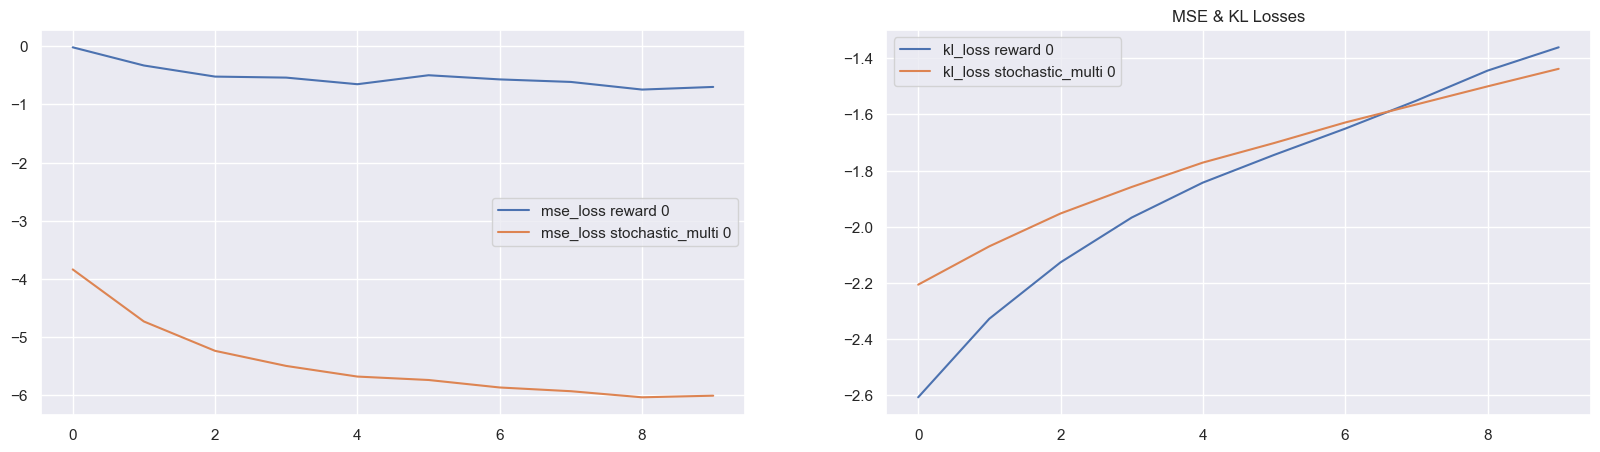

- MSE : 0.643780, KL : 0.273438


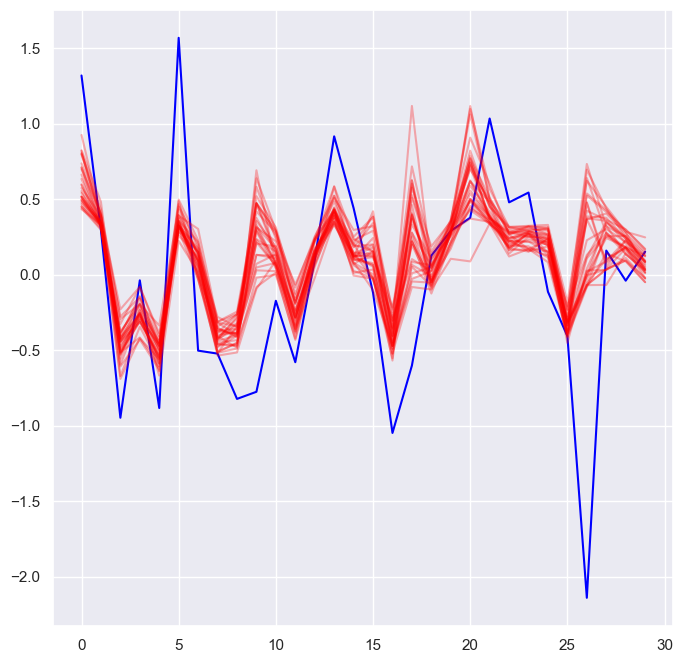

- MSE : 0.002157, KL : 0.250136


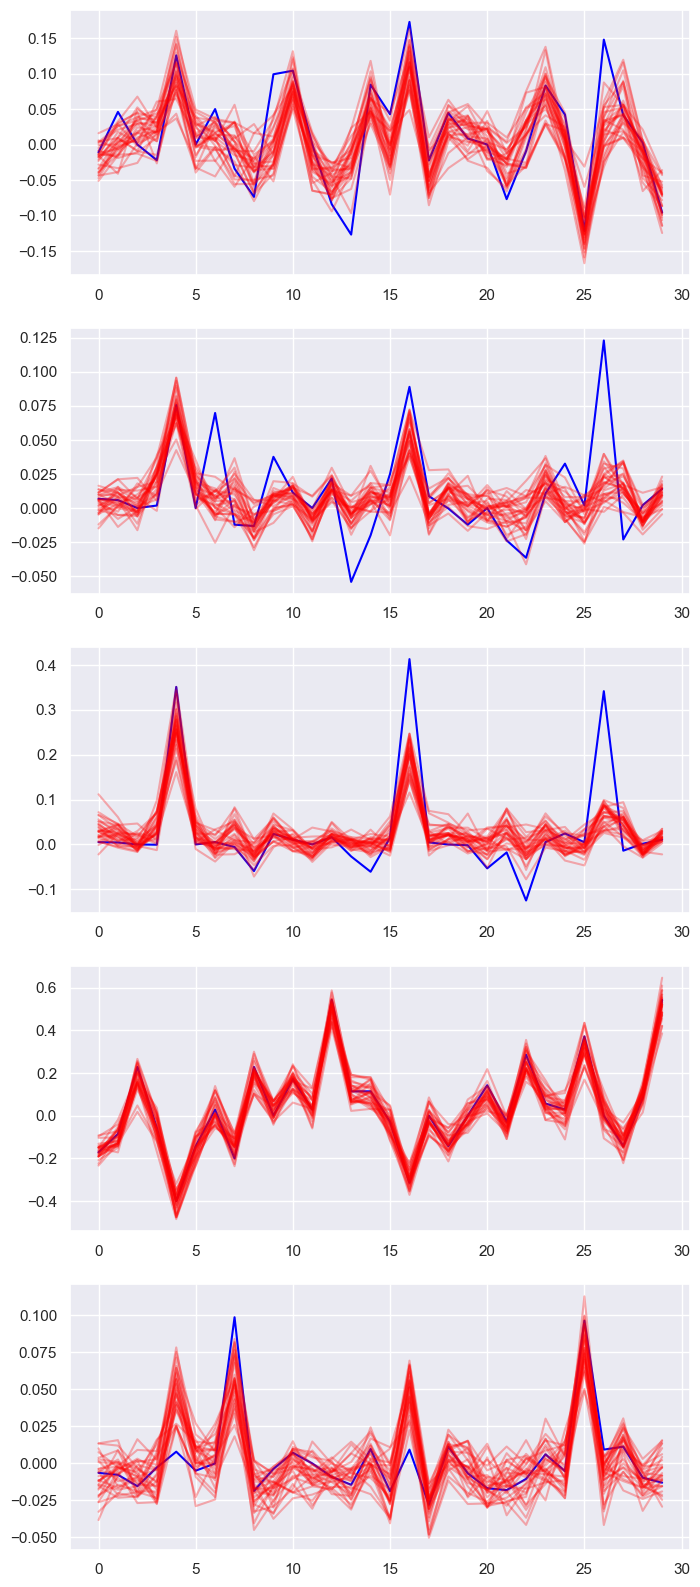

In [1]:
import typing
from simulation_env.environment_basic.environment_basic import CropRotationEnv as CropRotationEnv_Basic
from simulation_env.environment_maincrops.environment_maincrops import CropRotationEnv as CropRotationEnv_Advanced
from models.basic.DQN_Prioritized import DeepQAgent as DQN_Prioritized
from models.basic.DQN_Prioritized_Symbolic import DeepQAgent as DQN_Prioritized_Symbolic
from models.advanced.SAC import SACAgent
from models.advanced.SAC_Symbolic import SACAgent as SACAgent_Symbolic
from models.advanced.fake_env import FakeEnv
import numpy as np
from utils.experiment_utils import run_experiment, plot_experiment, plot_losses, plot_losses_sac
import torch
from torch import optim
from itertools import count
import collections
from numpy import random
import typing
import pprint
import optuna
from optuna.trial import TrialState
import math
from models.utilities.ReplayBufferPrioritized import UniformReplayBuffer, Experience
from models.advanced.model_utilities import format_samples_for_training, create_full_replay_buffer, plot_mse_and_kl_losses_per_key

from models.advanced.model_utilities import plot_validation_fit
import torch.nn as nn


seed = 43
random_state1 = np.random.RandomState(seed)
random_state2 = np.random.RandomState(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CropRotationEnv_Advanced(
    seq_len = 10, 
    random_state = random_state1,
    DryWetInit = None, 
    GroundTypeInit = None, 
    deterministic = False
    )




experience_buffer_size = 5000
experience_replay_buffer = create_full_replay_buffer(length = experience_buffer_size, seq_len=10, random_state = random_state1, batch_size = 128, device = device)

test_buffer_size = 500
test_replay_buffer = create_full_replay_buffer(length = experience_buffer_size, seq_len=10, random_state = random_state2, batch_size = 128, device = device)

_, test_experiences = test_replay_buffer.uniform_sample(replace = False,batch_size=500)
states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*test_experiences))
test_inputs, test_outputs = format_samples_for_training(
    states=states, 
    actions = actions, 
    rewards = rewards, 
    next_states = next_states,
    device = device,
    num_actions = env.num_crops,
    )



dynamics_model_batch_size = 256
num_dynamics_model_training_steps = 10

batch_size = 128
num_crops = 24
num_input_dimensions = 34+8*num_crops

# generate input indices:
input_action_idxs = list(range(num_crops))
input_condition_idxs = [24,25,26,27,28,29,30] + list(range(34+3*num_crops,34+8*num_crops))
input_prices_and_costs_idxs = [31,32,33] + list(range(34,34+3*num_crops))


# generate target indices:
target_reward_idx = 0
target_stochastic_multi_idxs = [1,2,3,4,7]
target_static_idxs = [5,6] + list(range(11+3*num_crops,11+8*num_crops))
target_prices_and_costs_idxs = [8,9,10] + list(range(11,11+3*num_crops))


custom_model_setting_dict = {    
    "stochastic_multi": {
        "type": "stochastic",
        "input_size": len(input_action_idxs + input_condition_idxs),
        "output_size": len(target_stochastic_multi_idxs),
        "num_hidden_units": 256,
        "num_hidden_layers": 1,
        "activation": nn.ReLU(),
        "input_idxs": input_action_idxs + input_condition_idxs,
        "target_idxs": target_stochastic_multi_idxs,
        "lr": 0.00089,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000135,
        "num_models": 1,
        "stochastic_layer_type": "stochastic_single"
    },
    "reward": {
        "type": "stochastic",
        "input_size": num_input_dimensions,
        "output_size": 1,
        "num_hidden_units": 256,
        "num_hidden_layers": 5,
        "activation": nn.ReLU(),
        "input_idxs": list(range(num_input_dimensions)),
        "target_idxs": [0],
        "lr": 0.001,
        "weight_decay": 9.18e-08,
        "kl_weight": 0.000135,
        "num_models": 1,
        "stochastic_layer_type": "stochastic_single"
    }
}


fake_env = FakeEnv(device = device, random_state = random_state1, custom_model_setting_dict=custom_model_setting_dict)
num_dynamics_models = fake_env.get_num_models()
dynamics_model_keys = fake_env.get_model_keys()
dynamics_all_mean_mse_losses = {}
dynamics_all_mean_kl_losses = {}
for model_key in dynamics_model_keys:
    dynamics_all_mean_mse_losses[model_key] = []
    dynamics_all_mean_kl_losses[model_key] = []

for i in range(100):
    print("Episode",i)
    fake_env.train(
        replay_buffer = experience_replay_buffer, 
        num_steps = num_dynamics_model_training_steps, 
        batch_size = dynamics_model_batch_size
    )
    if i%10 == 0:
        dynamics_mean_mse_losses, dynamics_mean_kl_losses = fake_env.eval(test_inputs, test_outputs)
        for model_key in dynamics_model_keys:
            dynamics_all_mean_mse_losses[model_key].append(np.log(dynamics_mean_mse_losses[model_key]))
            dynamics_all_mean_kl_losses[model_key].append(np.log(dynamics_mean_kl_losses[model_key]))

plot_mse_and_kl_losses_per_key(dynamics_all_mean_mse_losses, dynamics_all_mean_kl_losses)
plot_validation_fit(fake_env.model_loss_optimizer_pool, test_inputs, test_outputs, plot_range = 30)

In [89]:
import math
states, actions, rewards, next_states, dones = (torch.stack(vs,0).squeeze(1).to(device) for vs in zip(*test_experiences))
model_idxs_all_rollouts = [[0,0],[0,0],[0,0]]
l = 3
dynamics_next_states, dynamics_rewards = fake_env.predict_batch(
    states = states[:l],
    actions = actions[:l],
    model_idxs_all_rollouts = model_idxs_all_rollouts,
    device = device
)

idx = np.array(list(range(7,10+1*num_crops))) # [0,1,2,3,6]

# print(next_states[0][idx])
# print(dynamics_next_states[0][idx])
print(torch.concatenate((rewards[:l], dynamics_rewards.unsqueeze(1)), dim=-1))
print(np.square((rewards[:l]-dynamics_rewards.unsqueeze(1)).squeeze().cpu().numpy()))
print(np.mean(np.square((rewards[:l]-dynamics_rewards.unsqueeze(1)).squeeze().cpu().numpy())))


tensor([[ 1.3190,  0.8032],
        [ 0.2944,  0.3570],
        [-0.9483, -0.4078]], device='cuda:0', dtype=torch.float64)
[0.26602125 0.00392073 0.29211092]
0.187350967335861


In [77]:
num_crops = 24
target_gbm_idxs = np.array(list(range(7,10+3*num_crops)))
target_stochastic_multi_idxs = np.array([0,1,2,3,6])
target_previous_crops_idxs = np.array(list(range(10+3*num_crops,10+8*num_crops)))
target_static_idxs = np.array([4,5])


state = states[0]
action = actions[0]
next_state = next_states[0]
state_cpu = state.cpu()
action_cpu = action.cpu()
next_state_cpu = next_state.cpu()

fake_stochastic_multi = next_state[target_stochastic_multi_idxs]-state[target_stochastic_multi_idxs]
dynamic_next_state_cpu = fake_env.get_next_state_from_prediction(state=state,action=action, predicted_stochastic_multi=fake_stochastic_multi).cpu()
fake_stochastic_multi_cpu = fake_stochastic_multi.cpu()
# print(dynamic_next_state_cpu)
# print(next_state_cpu)
f = dynamic_next_state_cpu == next_state_cpu
print((dynamic_next_state_cpu[0][target_gbm_idxs]-next_state_cpu[target_gbm_idxs])/dynamic_next_state_cpu[0][target_gbm_idxs]*100)
# print()
# print((dynamic_next_state == next_state).all())

tensor([ -0.0687, -19.5529,  17.5923,  15.7976,  19.1671,   6.5882,   4.1226,
         16.6552,  17.2915,  25.8636,  25.8636,  17.5201,  31.5012,  32.4982,
         32.5892,  27.5379,  33.5969,  21.6689,  35.2008,  14.6686,  26.3461,
         22.9527,  17.8111,  22.1764,  10.3733,  25.5189,   5.9264,  -0.4580,
         -1.0227,  -0.8688,  -1.1194,  -2.2627,  -0.6645,  -2.8055,  -2.8055,
         -2.8202,  -4.7956,  -2.3583,  -3.8366,  -3.8514,  -1.6570,  -2.1186,
         -0.3526,  -1.9517,  -3.5583,  -5.9686,  -1.6272,  -0.3543,  -0.9790,
         -0.6942,   0.0000,   3.1955,   2.9321,   6.2933,   6.3786,   5.2962,
          3.5527,   6.5150,   6.5150,   6.2001,   6.4113,   6.7627,   6.4526,
          6.6873,   6.1350,   6.9860,   5.7105,   8.4292,  14.8352,   2.7203,
          5.1423,   6.0630,   5.5687,  15.3626,   4.5053])


In [6]:
rs = np.random.RandomState(42)
# print the state of the random seed
print(rs.get_state()[1][0])

42
